# Image classification from scratch
### 从零开始的图像分类

原始链接：https://keras.io/examples/vision/image_classification_from_scratch/

## Note:  
这是Keras Example中第一个计算机视觉样例，很多博主在引入Keras的时候会直接使用MNIST作为样本，并且代码总量能控制在30行以内，我其实是比较同意这种做法，因为“体验感”或者说是第一印象是非常重要的，我当初就是惊叹于Keras极简的代码风格后才开始使用。  

为此，与其说这是Keras的零基础引入，不如说是在有基本概念后的中级教程，如果对Keras完全不了解的可以先在用“Keras MNIST”关键字搜索一个代码量在50行以内的例子学习下，然后再来看本例。  

但这个案例实际上涵盖的内容非常丰富，对于想要进阶的读者来说是不可多得的好示例。

--------------------

## Introduction
This example shows how to do image classification from scratch, starting from JPEG image files on disk, without leveraging pre-trained weights or a pre-made Keras Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary classification dataset.  
这个例子展示了如何从零开始实现图像分类，从磁盘中读取JPEG的图像文件开始，而不是使用预训练好的模型或预制作好的应用。这里展示了Kaggle竞赛中**Cats vs Dogs**（猫狗大战）二分类数据集。

We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation.  
使用**image_dataset_from_directory**函数来制作数据集，然后用Keras的图像预处理层进行标准化和增强。


----------------

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

------------

## Load the data: the Cats vs Dogs dataset
Raw data download  
First, let's download the 786M ZIP archive of the raw data:  
首先下载一个786 MB的zip原始文件。  
在这里使用 “!”可以直接执行终端的命令，如果在Windows平台下无法使用curl命令的，可以根据以下链接进行操作：https://www.cnblogs.com/gered/p/10682298.html

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 1743k    0     0  1354k      0  0:09:54  0:00:01  0:09:53 1354k
  1  786M    1 8479k    0     0  3707k      0  0:03:37  0:00:02  0:03:35 3706k
  1  786M    1 14.3M    0     0  4482k      0  0:02:59  0:00:03  0:02:56 4481k
  2  786M    2 20.2M    0     0  4829k      0  0:02:46  0:00:04  0:02:42 4829k
  3  786M    3 26.0M    0     0  5053k      0  0:02:39  0:00:05  0:02:34 5844k
  4  786M    4 32.1M    0     0  5234k      0  0:02:33  0:00:06  0:02:27 6233k
  4  786M    4 37.3M    0     0  5243k      0  0:02:33  0:00:07  0:02:26 5945k
  5  786M    5 42.4M    0     0  5239k      0  0:02:33  0:00:08  0:02:25 5737k
  6  786M    6 47.5M    0     0  5240k      0  0:02

使用unzip解压包，Windows平台下如果无法使用unzip命令，可以按照如下链接进行操作：https://www.cnblogs.com/gcgc/p/10613155.html

In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

ImageClassificationFromScratch.ipynb
MSR-LA - 3467.docx
PetImages
kagglecatsanddogs_3367a.zip
readme[1].txt


In [3]:
!ls PetImages

Cat
Dog


## Filter out corrupted images
When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.  
在这个数据集中是存在损坏的图像的，即头中没有“JFIF”字符的编码错误文件，这里需要对数据进行滤除操作，这里的滤除是根据文件头是否包含“JFIF”字符串。

根据[维基百科](https://en.wikipedia.org/wiki/JPEG_File_Interchange_Format#File_format_structure)的词条可以知道，jpg文件头结构如下图所示。从图中可以发现，前11个bytes存储了基本信息。  
<img src="../images/CV_Img/jpgHead.png">

In [2]:
import os 

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            # fobj.peek(10)：从文件中读取前10个字节的数据，但并不会从读取流中删除，后面仍然可用
            # tf.compat.as_bytes("JFIF")：将“JFIF”这个字符串转为字节类型
            # .jpg 文件在开头中包含字符串“JFIF”，并且是按照ASCII方式编码的
            # 判断“JFIF”是否在文件头中
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # 删除损坏的图像
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


----------------

## Generate a Dataset
这里使用了 [**image_dataset_from_directory**](https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function) 函数，这个函数可以从目录中自动生成**tf.data.Dataset**类型的数据，同时会自动产生标签，标签依据是文件夹名。在这个案例中，文件组织结构如下：  
```python 
PetImages/  
    Cat/
        0.jpg
        1.jpg
        .....
    Dog/
        0.jpg
        1.jpg
        .....
```
调用函数 image_dataset_from_directory(directory='PetImages')后就可以自动按照Cat和Dog文件夹生成两类图片和标签。

In [3]:
image_size = (180, 180)
batch_size = 32

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size, # 在读入图像的时候就对其进行尺寸变化
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


---------------

## Visualize the data
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".  
随机从训练集中抽取了前9张图片作为展示，标签“1”代表“dog”，标签“0”代表“cat”。

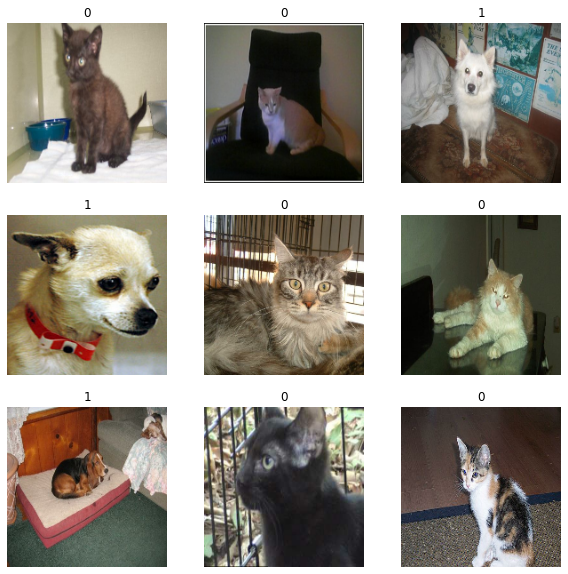

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

--------------

## Using image data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.  
没有足够多的图像数据集时，可以对图像进行随机但真实的变化，如随机的水平反转（镜像）或小角度的旋转。这将给模型提供训练集数据不同的方位（视角）以此来缓解过拟合。  

然而实际情况是，如果仅仅是图像分类任务中使用数据增强是无可厚非的，但如果你所使用到的图片将被用来完成回归任务，那么需要慎重考虑使用数据增强。因为回归问题可能需要使用图片中关键点的相对位置来计算距离，如果使用旋转则会造成这方面的变化。另一方面，也并不是所有分类问题都可以毫无保留地使用数据增强，最有名的例子就是“兔鸭问题”。  

<center class='half'>
    <img src="../images/CV_Img/duckOrRabbit.png" width=300><img src="../images/CV_Img/duckOrRabbit.png" width=300 style="transform:rotate(180deg);">
</center>

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:  
检查一张图片经过数据增强后的效果

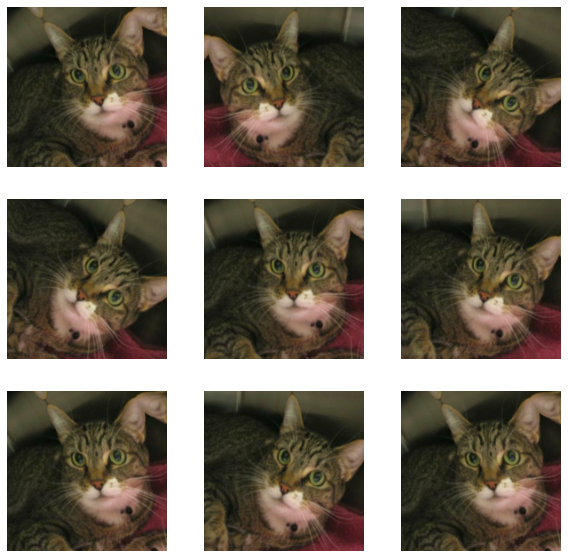

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

-----------

## Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.  
我们的图像已经是标准尺寸 (180x180)（在Generate a Dataset部分完成，image_size参数控制了图像尺寸），因为它们是由我们的数据集生成的连续 float32 批次。但是，它们的 RGB 通道值在 [0, 255] 范围内。这对于神经网络来说并不理想；通常，您应该设法使输入值变小。在这里，我们将通过在模型开始时使用 Rescaling 层将值标准化为 [0, 1]。  

由于神经网络的学习率通常是在1e-3这个尺度，考虑一个最坏的情况，每次参数修改值都等于学习率大小，那么参数从0到1则需要1000次训练，从0到255则需要255000次训练，所以对输入数据的标准化是常规操作。但这里还有一点需要注意，jpg格式的图片每个通道像素值域是[0, 255]，但png是[0, 1]，如果都png格式读入的数据进行除值标准化后会导致值域过小，模型有可能学不到任何东西，因为学习率说不定会大于数据的最大值。

--------------

## Two options to preprocess the data
There are two ways you could be using the data_augmentation preprocessor:  
这里提供了两种方法用作数据预处理

**Option 1: Make it part of the model**, like this:
```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
... 
```
With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration.  
这种方法将数据增强的操作和模型融合在一起，最大的好处在于可以将数据增强的步骤也使用GPU加速。  

Note that data augmentation is inactive at test time, so the input samples will only 
be augmented during fit(), not when calling evaluate() or predict().  
由于Tensorflow框架设定是仅仅在训练的时候fit会数据增强，而在评估evaluate和预测predict的时候并不会开启数据增强，用这种方式可以自动进行切换。  

If you're training on GPU, this is the better option.  
如果你是在GPU上进行训练，那么用这种方式是最佳的。

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of augmented images, like this:  
```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.  
使用这种方法，数据增强将在GPU上进行异步执行，并且在数据送入模型之前会保存到缓存中。  

If you're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.  
如果你是在CPU上进行训练，那么用这种方式最好，因为在训练过程中不会发生阻塞。

------------

## Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:  
为了确保充分使用缓冲区预读取而不引发IO阻塞，执行以下操作。  

**tf.data.prefetch()** 这个函数可以提前准备好下一次训练用的数据，让计算机资源尽可能不停歇

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

这里需要明确batch_size和buffer_size的区别。  

在深度学习中batch_size大小是可以控制模型性能的，但buffer_size是计算机缓冲区大小，虽然刚开始可以粗略将两个值设置成一样或近似，但我还是希望在这里提前引入另一个变量，**tf.data.AUTOTUNE**，这是TensorFlow的一个变量，它能够自动计算缓冲区大小，后面的示例中会大量出现这个变量的身影。所以上面的代码可以改写成如下形式：  

In [9]:
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

----------------

## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.   
这里构建了一个小版本的Xception网络，并没有对其进行超参数优化，如果你想对模型结构进行优化，可以考虑使用[KerasTuner](https://github.com/keras-team/keras-tuner)。  

KerasTuner的使用方法将在这个仓库CV部分完成的差不多时开一个专栏进行介绍，这个工具十分强大，是做模型剪枝的利器。  

Note that:  
1. We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
2. We include a Dropout layer before the final classification layer.

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block 图像数据增强模块
    x = data_augmentation(inputs)

    # Entry block 入口模块或称为头模块
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual 旁侧残差支路

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual 残差支路变化，为了让支路和主路的数据维度保持一致
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual 残差短接
        previous_block_activation = x  # Set aside next residual 将短接后的数据再次设置为残差支路

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)  # 默认按照channel通道进行池化
    if num_classes == 2:
        activation = "sigmoid"  # 二分类使用 sigmoid
        units = 1
    else:
        activation = "softmax"  # 多分类使用 softmax
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

**GlobalAveragePooling2D** 这层比较特殊，很多人在Debug的时候一直找不到shape不一致的地方在哪，特别是发现维度不一致是多出来一个维度，那么大概率是因为少了这层。  

另外，对于图像处理任务中Flatten层的使用会逐渐减少，因为这个层并没有做计算操作，仅仅是将数据变成了一个行向量，如果后面接入了Dense层，那么整个模型的参数会急剧增加。

In [12]:
model = make_model(input_shape=image_size + (3,), num_classes=2)

-------------

## Train the model

In [17]:
epochs = 5

## 设置回调函数

In [15]:
callbacks = [
    # 原文中并没有 save_best_only 这个参数，这样做是非常危险的，因为他会保存每一个训练好的模型，数量=epochs
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", save_best_only=True) ,
    # 也可以在这里添加Tensorboard回调
    keras.callbacks.TensorBoard(log_dir='logs')  
]

## 编译模型  
原文中提供的是使用字符串方式进行编译：
```python
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
```
但我个人更推荐以下这种方式，因为你需要明确知道自己想让模型实现什么功能，参考[Tensorflow Core](https://tensorflow.google.cn/api_docs/python/tf/metrics)

In [16]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=keras.losses.BinaryCrossentropy(), 
    metrics=keras.metrics.BinaryAccuracy()
)

## 训练模型
原文中没有引入history：
```python
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
```
但实际上用history类来记录模型在训练过程中产生的loss值等信息是十分方便的，因为可以直接保存成txt文件。

In [18]:
histroy = model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,)

C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/5
586/586 [==============================] - 134s 212ms/step - loss: 0.5996 - binary_accuracy: 0.6818 - val_loss: 0.5059 - val_binary_accuracy: 0.7620
Epoch 2/5
586/586 [==============================] - 122s 209ms/step - loss: 0.4241 - binary_accuracy: 0.8037 - val_loss: 0.4179 - val_binary_accuracy: 0.8292
Epoch 3/5
586/586 [==============================] - 122s 207ms/step - loss: 0.3206 - binary_accuracy: 0.8598 - val_loss: 0.2839 - val_binary_accuracy: 0.8757
Epoch 4/5
586/586 [==============================] - 123s 210ms/step - loss: 0.2711 - binary_accuracy: 0.8825 - val_loss: 0.2608 - val_binary_accuracy: 0.8937
Epoch 5/5
586/586 [==============================] - 122s 209ms/step - loss: 0.2289 - binary_accuracy: 0.9054 - val_loss: 0.1850 - val_binary_accuracy: 0.9257


----------------

## Run inference on new data
Note that data augmentation and dropout are inactive at inference time.  
用模型进行推断，在推断过程中数据增强和dropout功能层是不使用的

This image is 94.58 percent cat and 5.42 percent dog.


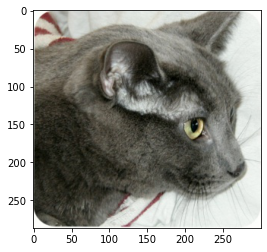

In [24]:
image_path = "PetImages/Cat/6779.jpg"

img = keras.preprocessing.image.load_img(
    image_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis 将图像展开一个batch维度

predictions = model.predict(img_array)
score = predictions[0]

img = plt.imread(image_path)
plt.imshow(img)

print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

--------------

## 显示显卡信息
如果想要在代码中显式显卡信息，可以使用下面的语句，此处参考了 **mjiansun** 的博客 [python查看显卡gpu信息](https://blog.csdn.net/u013066730/article/details/82756379)。但需要提前安装 **pynvml**包

In [25]:
!pip install pynvml

In [27]:
from pynvml import *

nvmlInit()
print("Driver Version:", nvmlSystemGetDriverVersion())   #显卡驱动版本
deviceCount = nvmlDeviceGetCount()#几块显卡
for i in range(deviceCount):
    handle = nvmlDeviceGetHandleByIndex(i)
    print("Device", i, ":", nvmlDeviceGetName(handle))   #具体是什么显卡
nvmlShutdown()
 

Driver Version: b'460.89'
Device 0 : b'GeForce RTX 2060'
